In [1]:
### Requirements: PyDotPlus, Matplotlib, Scikit-Learn, Pandas, Numpy, IPython (and possibly GraphViz)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import sklearn
import sklearn.metrics as skm
from scipy import misc
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image, YouTubeVideo

def visualize_tree(tree, feature_names, class_names):
    dot_data = StringIO()  
    sklearn.tree.export_graphviz(tree, out_file=dot_data, 
                         filled=True, rounded=True,  
                         feature_names=feature_names,
                         class_names=class_names,
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

# EECS 545: Machine Learning
## Lecture 24: Decision Trees, Bagging, Boosting
- Instructor: **Jacob Abernethy**
- Date: April 13, 2016

Lecture Exposition Credit: Valliappa Chockalingam

### Interpreting Learned Models of ML algorithms

- Many of the more sophisticated ML algorithms are often hard to interpret. Some reasons for this include: 
 - Complicated or High-Dimensional Mainfolds or Decision Boundaries 
 - Uncalibrated Probabilities (Prediction Probabilities which cannot be interpreted as confidence levels)
 - Engineered Features that do not have some obvious meaning
 - Hyperparameters whose effects are not fully understood
 - ...

### Lecture Overview

In this lecture we will:
- Look at a class of ML algorithms that are particularly good in the sense that the learned model is in general interpretable. (***Decision Trees***)
- Consider some "meta-algorithms" that combine learned models (***Ensemble Learning***), particularly for:
    - Improving stability and reducing variance (***Bagging***) and,
    - Learning from some set of "weak" models. (***Boosting***)

### Motivating Example: 20 Questions (1)
(Example: http://en.akinator.com)

- Famous game where a player thinks of something and another player must guess what that thing is.
 - Many variants: People, Animals, Music, ...
- Premise: I am thinking of a person. Ask me up to 20 yes/no questions to determine who this person is that I am thinking about.

### Motivating Example: 20 Questions (2)
#### (Things to think about)
- The questions (and possibly their order as well) matter a lot! 
 - Which ones should you choose? (These will determine features!)
 - When should you ask them?
- With 20 questions each with a binary answer, one can distringuish at the most $2^{20} = 1,048,576$ people. 
 - Still far less than the number of people anyone really knows. Does this mean playing this game and winning is in some sense easy?
- If you were to develop such an A.I. what kind of algorithms/techniques would you choose? (Decision Trees are just one possibility!)

### An "obvious" representation: Classification Decision Trees (1)

- Observations are classified into two or more classes, coded by a response variable $Y$ taking values $\in \{1, 2, . . . , K\}$.
- We have a feature vector $\mathbf{x} = (x_1, x_2, ..., x_p)$, and we hope to build a classification rule $C(\mathbf{x})$ to assign a class label to $\mathbf{x}$.
- We have a sample of pairs $(\mathbf{x}_i, y_i), i = 1, ..., n$. Note that each of the $\mathbf{x}_i$ are vectors $\mathbf{x}_i = (x_{i1},x_{i2}, ..., x_{ip})$.
- An Example: $Y$ indicates whether an E-mail is spam or not. $\mathbf{x}$ is bag-of-words representation of the email.

### Classification Decision Trees (2)

- As the name suggests, the main data structure is a Tree.
- Each node represents a value query on one of the variables — e.g. “Is $x_3$ > 0.4”. If the answer is “Yes”, go right, else go left.
- The leaf nodes are the decision nodes where a classification is made.
- New observations $\mathbf{x}$ are passed from the root down to a terminal node of the tree, and then a majority vote is used to choose which class it should be assigned (Note: This vote is often implicit).

In [2]:
# Decision Tree Example: Poisonous/Edible Mushroom Classification 
# (from the UCI Repository)
data = pd.read_csv('agaricus-lepiota.data', header=None)
# Preprocessing (Note: Label Encoder is a very useful tool to convert categorical data!)
le = preprocessing.LabelEncoder()
# Change columns from labels to integer categories 
#(See agaricus-lepiota.data for the initial labels and 
# agaricus-lepiota.names for a full description of the columns)
data = data.apply(le.fit_transform)
# Use a Decision Tree with maximum depth = 5
dt_classifier = DecisionTreeClassifier(max_depth=5)
dt = dt_classifier.fit(data.ix[:,1:], data.ix[:,0])

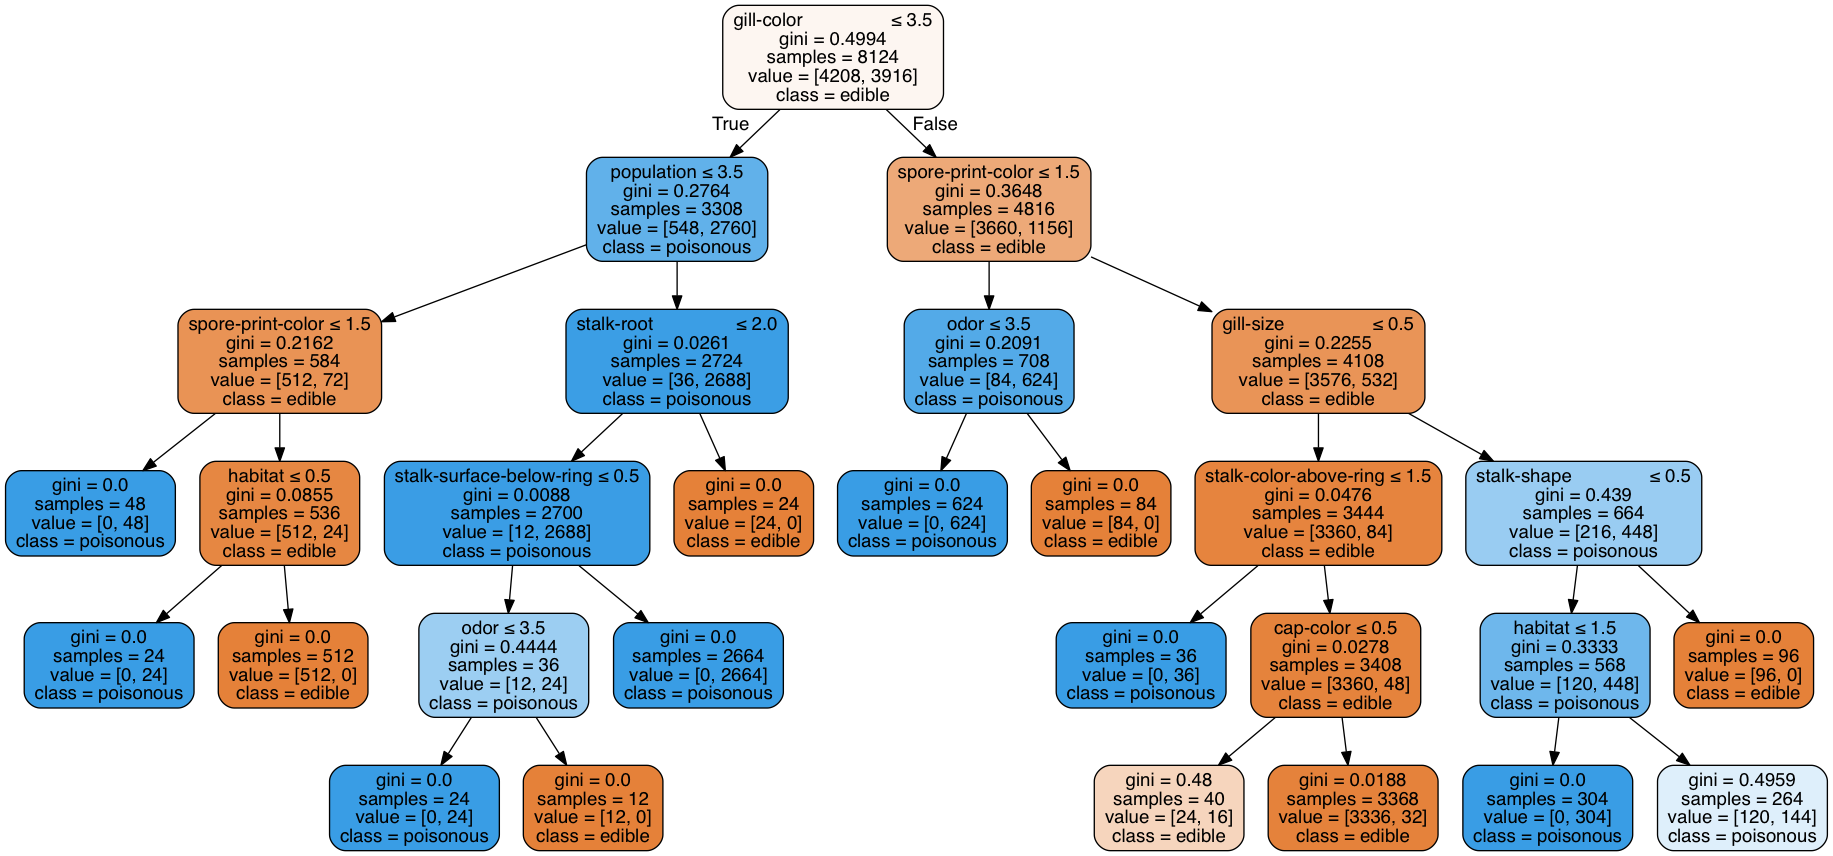

In [3]:
# Visualize the decision tree with class names and feature names (See the first cell for the function)
Image(visualize_tree(dt, feature_names = 
                     open('agaricus-lepiota.feature-names').readlines(), 
                     class_names = ['edible', 'poisonous']))

### Decision Tree Example: Fruits
#### Note: This example illustrates that Decision Trees don't have to be binary trees or involve binary classification.

![DecisionTreeExample](images/DecisionTreeExample.png)

### Decision Tree Construction Ideas

- The general idea behind decision trees like any other classification algorithm is to partition the space of inputs based on their corresponding classes.
- Moreover, we are looking for the "best split" at each level. 
 - Often explained using an "impurity" measure or metric which tells us how certain a classification can be made using a particular query and all previously gained information. 
- We repeat the "best splitting" procedure recursively in a Divide and Conquer fashion.

### Metrics: Information Gain (Mutual Information)
#### Used by the ID3, C4.5 and C5.0 tree-generation algorithms. 
  
$$\text{Information Gain = Entropy(Parent) - } \\ \text{ Weighted Sum of Entropy(Children)} \\ = IG(P,a) = H(P) - H(P|a)$$

Where recall, $\text{H(p)} = -\sum \limits_{i = 1}^{k_m} p_i \log_2 p_i$ where the query is concerned with some feature $x_k$ and the query has $k_m$ responses.

### A question to illustrate the Information Gain metric

Note:
 - The $[x+, y-]$ indicate the number of samples belonging to the two classes, say positive and negative. 
 - The topmost one denotes the number of positive and negative samples in the dataset before "any partitioning."

![DecisionTreeExample](images/InformationGain.png)

### Answer

- Entropy of the dataset, say $D$: 
$H(D) = -\left(\frac{29}{29 + 35} \log_2 \frac{29}{29 + 35} + \frac{35}{29 + 35} \log_2 \frac{35}{29 + 35}\right) = 0.99365071169$. So:

    - $H(D|A1) =  -\left(\frac{21}{21 + 5} \log_2 \frac{21}{21 + 5} +  \frac{5}{21 + 5} \log_2 \frac{5}{21 + 5}\right) = 0.70627408918$
    - $H(D| \neg A1) = -\left(\frac{8}{8 + 20} \log_2 \frac{8}{8 + 30} + \frac{30}{8 + 30} \log_2 \frac{30}{8 + 30}\right) = 0.74248756954$


### Answer (Continued): Calculation of Weighting for Children when using Attribute $A1$

- Weighting for $A1 = $ $\frac{21 + 5}{29 + 35} = \frac{26}{64} = 0.40625$
- Weighting for $\neg A1 = $ $\frac{8 + 30}{29 + 35} = \frac{38}{64} = 0.59375$

### Answer (Continued): Weighted Sum of Entropy and Final Information Gain Calculation
- Weighted Sum of Entropy of Children = $0.70627408918 \cdot 0.40625 + 0.74248756954 \cdot 0.59375 = 0.7277758431$
- Therefore, the information gain using attrbiute $A1 = 0.99365071169 - 0.7277758431 = 0.2658748686$

### Answer (Continued): Final Answer

Repeating the process shown for attribute $A2$, we get that the information gain for attribute $A2 = 0.12143188346$ < the information gain for attribute $A1 = 0.2658748686$.

### So, what is Information Gain?

- Intuitively, Information Gain captures: 
 - The mutual information that there is between an attribute and the class labels, or, equivalently, 
 - The reduction in entropy gained by observing an attribute.
- Another intersting note: 
 - Mutual information (i.e., Information Gain) and KL-divergence are connected: $IG(X, Y) = D_{KL}(p(x, y) \mid \mid p(x)p(y))$.

### Metrics: Misclassification Error

$I(N) = 1 - \max \limits_{i} P(i \mid N)$ for a query node $N$

- Measures misclassification error made by a node.
- Maximum $(1 - 1/K)$ when samples are equally distributed among all classes, implying node $N$ provides really no information. (Note: $K$ is the number of classes)
- Minimum $(0.0)$ when all samples belong to one class, implying node $N$ provides enough information to be fully certain in the classification.

###  Metrics: Gini Impurity
#### Used by the CART (Classification and Regression Tree) Algorithm.
- A measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset. 
- To compute Gini impurity for a set of  m  items, suppose $i \in \{1, 2, ..., m\}$, and let $f_i$ be the fraction of items labeled with value $i$ in the set.
    $$I_{G}(f) = \sum_{i=1}^{m} f_i (1-f_i) = \sum_{i=1}^{m} (f_i - {f_i}^2) = \\ \sum_{i=1}^m f_i - \sum_{i=1}^{m} {f_i}^2 = 1 - \sum^{m}_{i=1} {f_i}^{2} = \sum_{i\neq k}f_i f_k$$ 

In [4]:
%matplotlib inline

def gini(p):
    return (p) * (1 - p) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

def plot_impurity_metrics():
    x = np.arange(0.0, 1.0, 0.01)
    entropy_t = [entropy(p) if p != 0 else None for p in x]
    entropy_scaled_t = [0.5 * i if i != None else None for i in entropy_t]
    gini_t = [gini(p) for p in x]
    error_t = [error(p) for p in x]

    fig = plt.figure()
    ax = plt.subplot(111)

    for i, lab, ls, c in zip([entropy_t, entropy_scaled_t, gini_t, error_t], 
                             ['Entropy', 'Entropy (Scaled)', 'Gini', 'Misclassification Error'], 
                             ['-', '-', '--', '-.'], ['black', 'lightgray', 
                             'red', 'lightgreen', 'cyan']):
        line = ax.plot(x, i, label = lab, linestyle = ls, color = c, lw = 2)
    ax.legend(loc = 'upper center', ncol = 3, bbox_to_anchor = (0.5, 1.15), fancybox = True, shadow = False)
    ax.axhline(y = 1, linewidth = 1, color = 'k', linestyle = '--')
    ax.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
    plt.ylim([0, 1.1])
    plt.xlabel('p(Attribute = True)')
    plt.ylabel('Impurity Index')

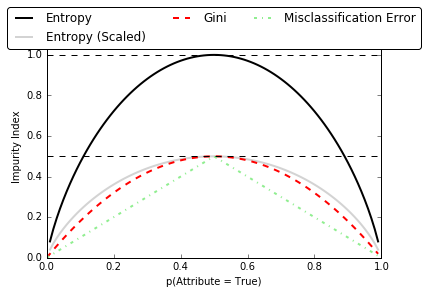

In [5]:
# The Metrics Illustrated in a Graph For a 2-Class Problem 
plot_impurity_metrics()
# Note: The Gini Impurity Index is in between the misclassifcation 
#       error curve and the scaled Entropy Curve!

### Choosing an Impurity Measure
All three measures are similar, and often construct identical trees. However:
- Entropy and Gini are differentiable, and hence more subject to numerical optimization.
- Entropy and Gini are more sensitive to changes in the node probabilities than Misclassification error.
- Entropy maybe slow to compute.
- Entropy is suggested for exploratory analysis as it is based on mutual information and thus may reveal insights about the data.
- Gini Impurity is suggested to minimize misclassification (see the note on the previous slide.)

### Pseudocode Iterative Dichotomizer 3 (ID3)

* ID3 was first "decision tree" alg.
* Precursor to C4.5 Alg. [More here](https://en.wikipedia.org/wiki/ID3_algorithm)

<img width=80% src="images/ID3Pseudocode.png">

### The Value of Labeled Data
- Labeled data is often hard to come by, various approaches can be taken to mitigate this however.
- In general, we can use many semi-supervised techniques.
- Active Learning is a particularly notable one, used in for example 20-Questions like games.

In [6]:
### Decision Tree Active Learning Example: Animal Game 

import string

class node :
    "Node objects have a question, and  left and right pointer to other nodes"
    def __init__ (self, question, left=None, right=None) :
        self.question = question
        self.left     = left
        self.right    = right

def yes (ques) :
    "Force the user to answer 'yes' or 'no' or something similar. Yes returns true"
    while 1 :
        ans = raw_input (ques)
        ans = string.lower(ans[0:1])
        if ans == 'y' : return 1
        elif ans == 'n' : return 0

knowledge = node("bird")

def active_learning_example (suppress=True) :
    "Guess the animal. Add a new node for a wrong guess."
    first = True
    while not suppress and (first or yes("Continue? (y/n)")):
        if first: 
            first = False
        print
        if not yes("Are you thinking of an animal? (y/n)") : break
        p = knowledge
        while p.left != None :
            if yes(p.question+"? ") : p = p.right
            else                    : p = p.left
    
        if yes("Is it a " + p.question + "? ") : continue
        animal   = raw_input ("What is the animals name? ")
        question = raw_input ("What question would distinguish a %s from a %s? "
                                            % (animal, p.question))
        p.left     = node(p.question)
        p.right    = node(animal)
        p.question = question
    
        if not yes ("If the animal were %s the answer would be? (y/n)" % animal) :
            (p.right, p.left) = (p.left, p.right)

In [7]:
# Interactive Active Learning Example
# Change suppress to False and run this cell to see demonstration
active_learning_example(suppress=True)

### Generalizations of Decision Trees (1)
- Decision Trees in their simplest form involve:
 - A 2-class scenario, with, 
 - Binary Features, and use a,
 - Binary Tree (every node has at most 2 children).
  
However, generalizations are possible.

### Generalizations of Decision Trees (2)
- Categorical Features 
 - Can use $n$-ary trees rather than binary search trees 
   - Fruits Tree Example: Color? asked at the root had three choices: Red, Yellow or Green (Ternary Tree)
 - Can use questions such as "$x_i$ = $l$?" or even $"2 \leq x_i \leq l$?", where $x_i \in \{1, ..., l, ..., K\}$?
   - The Mushroom Classification Tree was an example of this (Binary Tree with comparative rather than only equality checking conditions).

### Generalizations of Decision Trees (3)
- Categorical Output/Multiclass Scenario (the Fruits Example)
 - One way to handle categorical outputs is to pose a question such as "Is it a bird?" when "Yes" is expected. This keeps the outputs binary. 
    Moreover, if the answer is no, one can then use active learning as shown before to improve the tree.
 - Another way is to simply use a one-hot encoding for the output (Ex: Bird corresponds to $[0, 0, 0, 0, 0, 1, 0]$) 
- Real-Valued Response (Output) - Owing to the nature of trees, regression usually involves discretizing the output space either in some way. Once discretized, everything is the same.

### Inductive Bias

- What is the policy by which a particular decision tree algorithm generalizes from observed training examples to classify unseen instances?

- ***Definition:*** The set of assumptions that, together with the training data, deductively justify the classifications assigned by the learner to future instances.

- We can also think of this bias as an algorithms preference.

[More here](https://en.wikipedia.org/wiki/Inductive_bias)

### Inductive Bias of Decision Tree Algorithms

- When a decision tree is built, it is almost always not the only tree that will perfectly classify the training set!
- Finding the inductive bias of a decision tree algorithm is basically trying to find the type of tree that the algorithm favors in general. 
- It turns out that two of the common decision tree algorithms (ID3 and C4.5) have the same approximate inductive bias:
 - Prefers shorter trees over larger trees, and,
 - Trees that place high information gain attributes close to the root over those that do not. 

### Occam's Razor

- If a larger tree classifies the training set just as well as the shorter hypothesis, then we would logically want to use the shorter tree as it performs the same, is smaller, and is quicker to build.
- But is it always the case that shorter, more simpler hypotheses are preferred over larger ones? 
- This is a question that has been debated for centuries, and the answer still remains unclear. 
- This bias of preferring the simplest hypothesis that fits the data is known as Occam's razor. That is, "the simpler the better."

### Decision Tree Limitations (1)

Decision Trees in general perform well with lots of data, are robust to violations of assumptions, and probably most strikingly are easy to understand and interpret. However:
 - The problem of Learning an optimal Decision Trees is NP-Complete under several definitions of optimal.
  - Standard algs are "greedy", make myopic decisions that may not be globally optimal.
 - There are concepts that are hard to learn using Decision Trees, which are also generally hard for other linear classifiers, as the Decision Tree learned is prohibitively large. These include "toy" problems such as: 
  - XOR, Parity or Multiplexer based Problems

## Break time!

![](images/surprised_cat.gif)

### Decision Tree Limitations (2) 

Finally, what is in some sense the motivation for the next part of this lecture:
 - Decision-tree learners can create over-complex trees that do not generalise well from the training data (Overfitting). 

### Dealing with Overfitting

- Simple Method: Grow the tree and check error iteratively, stop at a point where error rate is satisfactory or tree has reached some limit.
- **Pruning**: Construct a large decision tree. Use a method such as cross-validation and prune nodes from the leaves upwards. If removing a node does not change performance, make the change permanent. This can also be done for entire subtrees.
- Use Ensemble Methods!

### Ensemble Methods
- Supervised ML can be viewed as finding a hypothesis for good predictions. 
- Finding a single hypothesis within the hypothesis space that gives good predictions can be hard.  
- Idea of Ensemble Methods: Combine multiple hypotheses to form a (hopefully) better hypothesis.
- ***Note***: The hypothesis represented by an Ensemble Model is not necessarily contained within the hypothesis space of the constituent models!

### Bagging (**B**ootstrap **Agg**regat**ing**)

- Given a datset $\mathcal{D}$, $|\mathcal{D}| = n$.
- Create multiple ***bootstrap samples*** $\mathcal{D}^{'}_i, i \in \{1, ..., m\}$ such that $\forall i, |\mathcal{D}^{'}_i| = n^{'}$ using ***sampling with replacement.***
- Fit $m$ models using the above $m$ bootstrap samples 
 - ***Note:*** No pruning or stopping is used. Bagging helps when the models are unstable and can hurt if they are not.
- Given a new input $\mathbf{x}$, run each of the $m$ classifiers and use majority voting to classify $\mathbf{x}$.

***Note:*** Bagging can also be applied for regression but instead of using majority vote, the average is used.

### Why does Bagging make sense / What's the intuition?

- With one large Decision Tree (or more generally a single complex hypothesis), the model will likely have Low Bias and High Variance (Overfits to the "random noise" in the data).
- (Large) Decision Trees are unstable (using slightly different datasets causes a big change in the model learned).
- So, once we train multiple Decision Trees (or in general, multiple unstable ML models), with the bootstrap samples, we can get a much more stable model that performs better by say, using majority voting. 

In [8]:
%matplotlib inline

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

def bias_variance_example():
    X_train = []
    y_train = []

    for i in range(n_repeat):
        X, y = generate(n_samples=n_train, noise=noise)
        X_train.append(X)
        y_train.append(y)

    X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

    # Loop over estimators to compare
    for n, (name, estimator) in enumerate(estimators):
        # Compute predictions
        y_predict = np.zeros((n_test, n_repeat))

        for i in range(n_repeat):
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)

        # Bias^2 + Variance + Noise decomposition of the mean squared error
        y_error = np.zeros(n_test)

        for i in range(n_repeat):
            for j in range(n_repeat):
                y_error += (y_test[:, j] - y_predict[:, i]) ** 2

        y_error /= (n_repeat * n_repeat)

        y_noise = np.var(y_test, axis=1)
        y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
        y_var = np.var(y_predict, axis=1)

        print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
              " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                          np.mean(y_error),
                                                          np.mean(y_bias),
                                                          np.mean(y_var),
                                                          np.mean(y_noise)))

        # Plot figures
        from pylab import rcParams
        rcParams['figure.figsize'] = 9, 9
        plt.subplot(2, n_estimators, n + 1)
        plt.plot(X_test, f(X_test), "b", label="$f(x)$")
        plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

        for i in range(n_repeat):
            if i == 0:
                plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
            else:
                plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

        plt.plot(X_test, np.mean(y_predict, axis=1), "c",
                 label="$\mathbb{E}_{LS} \^y(x)$")

        plt.xlim([-5, 5])
        plt.title(name)

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})

        plt.subplot(2, n_estimators, n_estimators + n + 1)
        plt.plot(X_test, y_error, "r", label="$error(x)$")
        plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
        plt.plot(X_test, y_var, "g", label="$variance(x)$"),
        plt.plot(X_test, y_noise, "c", label="$noise(x)$")

        plt.xlim([-5, 5])
        plt.ylim([0, 0.1])

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})
    plt.show()

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


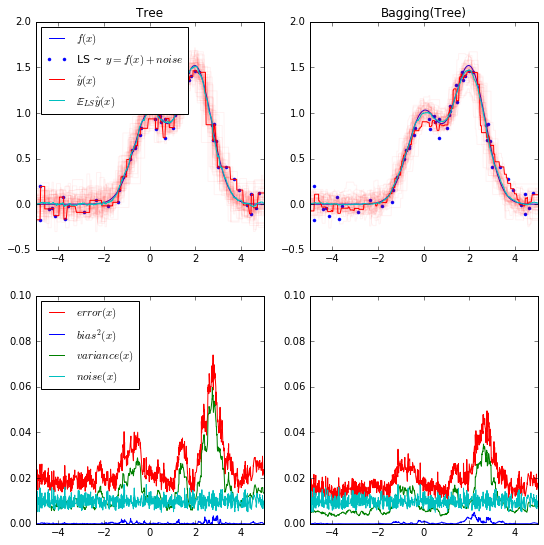

In [9]:
# Bias-Variance of Bagging with 
# Decision Tree Regressors Illustration (Adapted from ELSII, 2009)
# (Note: LS refers to a bootstrap sample)
bias_variance_example()

### Informal Bias-Variance Reasoning when using Bagging

- In general, the Bias remains about the same as we are performing model averaging and as long as the bootstrap samples represent the dataset well, the bias stays about the same.
- Variance reduces by a factor of at most the size of the bootstrap samples ($n^{'}$).
- In reality, bagging reduces variance (often by less than a factor of $n^{'}$) and tends to slightly increase bias.

### Random Forests

- Extends Bagging and in practice performs generally better.
- The only difference: When constructing the trees, best splits are found on only **a subset of the features**, not all.
 - Rule of thumb: $m = \sqrt{p}$ (rounded down) is recommended for classification problems and $\frac{p}{3}$ (rounded down) is recommended for regression where $p$ is the number of features.
- For each tree grown on a bootstrap sample, we can measure the error rate on a test set.
 - This is called the "out-of-bag" error rate.
 - This can be regarded as a generalization error and can provide a ranking of the importance of features. 

### Limitations of Bagging

- Loss of interpretability: the final bagged classifier is not a tree, and so we forfeit the clear interpretative ability of a classification tree.

- Computational complexity: we are essentially multiplying the work of growing a single tree by $m$. Can be a lot of work!

### Boosting  

- Bagging can help in reducing Variance. Are there methods that reduce both Bias and Variance? Yes! Boosting is one of them.
- General Ideas:
 - Weighted Majority Vote (unlike Bagging)
 - Elements of Ensemble built Sequentially (unlike Bagging where the models could be built parallely) 

### Boosting (2 Class Scenario)

- Assume class labels are -1 and +1.
- The final classifier then has the form: 
 - $h_T(\mathbf{x}) = \text{sgn}\left(\sum \limits_{t = 1}^T \alpha_t f_T(\mathbf{x})\right)$ where $f_1, ..., f_T$ are called base classifiers and $\alpha_1, ..., \alpha_T > 0$ reflect the confidence of the various base classifiers.

### Base Learners

- Let $(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)$ be the training data.
- Let $\mathscr{F}$ be a fixed set of classifiers called the base class.
- A base learner for $\mathscr{F}$ is a rule that takes as input a set of weights $\mathbf{w} = (w_1, ..., w_n)$ such that $w_i \geq 0, \sum w_i = 1$, and outputs a classifier $f \in \mathscr{F}$ such that the weighted empirical risk $$e_w(f) = \sum \limits_{i = 1}^n w_i \mathbb{1}_{\{f(\mathbf{x}_i) \neq y_i\}}$$ is (approximately) minimized.

### Examples of Base Learners

- Decision Stumps, i.e., decision trees with depth 1
- Decision Trees
- Radial Basis Function, i.e., $$f(\mathbf{x}) = \pm \text{sign}(k_\sigma(\mathbf{x}, \mathbf{x}_i) + b)$$ where $b \in \mathbb{R}$ and $k_\sigma$ is a radial kernel.

### AdaBoost (Adaptive Boosting)

- The first concrete algorithm to successfully realize the boosting principle.

<img src="images/adaboost.gif" width=35%>

### AdaBoost Algorithm

An *iterative* algorithm for "ensembling" base learners

- Input: $\{(\mathbf{x}_i, y_i)\}_{i = 1}^n, T, \mathscr{F}$, base learner
- Initialize: $\mathbf{w}^{1} = (\frac{1}{n}, ..., \frac{1}{n})$
- For $t = 1, ..., T$
 - $\mathbf{w}^{t} \rightarrow \boxed{\text{base learner}} \rightarrow f_t$
 - $\alpha_t = \frac{1}{2}\text{ln}\left(\frac{1 - r_t}{r_t}\right)$ where $r_t := e_{\mathbf{w}^t}(f_t)$
     - Recall $e_{\mathbf{w}}(f) := \sum \limits_{i = 1}^n \mathbf{w}_i \mathbf{1}_{\{f(\mathbf{x}_i) \neq y_i\}}$
 - $w_i^{t + 1} = \frac{\mathbf{w}_i^t \exp \left(- \alpha_ty_if_t(\mathbf{x}_i)\right)}{z_t}$ where $z_t$ normalizes.
- Output: $h_T(\mathbf{x}) = \text{sign}\left(\sum \limits_{t = 1}^T \alpha_t f_t(\mathbf{x})\right)$

## AdaBoost in Action

In [10]:
YouTubeVideo('k4G2VCuOMMg')

### Strong and Weak Learnability

- Boosting's roots are in the Probably Approximately Correct "PAC" (Leslie Valiant) learning model
- Get random examples from an unknown, arbitrary distribution.
- For ***any*** distribution, given polynomially many examples (and polynomial time), a ***Strong PAC learning algorithm*** can, with high probability, find a classifier with ***arbitrarily small*** generalization error. 
- Weak PAC Learning Algorithm can do the same except the generalization error only needs to be ***slightly better than random guessing*** $\left(\frac{1}{2} - \gamma\right)$.

### Weak Learning

- Adaboost is justified by the following result.
- Let $\gamma_t = \frac{1}{2} - r_t$. Recall that $r_t = e_{\mathbf{w}^t}(f_t)$ the weighted empirical risk.
- Note that we may assume $\gamma_t \geq 0 \leftrightarrow r_t \leq \frac{1}{2}$.
- If not, just replace $f_t$ with $-f_t$ and note that for any $f$ and $\mathbf{w}$, $$e_\mathbf{w}(f) + e_\mathbf{w}(-f) = 1$$

### Theorem
(Proof in Mohri et. al, Foundations of Machine Learning, 2012)
- The training error of Adaboost satisfies $\frac{1}{n} \mathbb{1}_{\{h_T(\mathbf{x}_i) \neq y_i\}} \leq \exp(-2\sum \limits_{t = 1}^T \gamma_t^2)$
- In particular, if $\forall t, \gamma_t \geq \gamma > 0$ then $\frac{1}{n} \mathbb{1}_{\{h_T(\mathbf{x}_i) \neq y_i\}} \leq \exp(-2\sum \limits_{t = 1}^T \gamma^2)$

### Weak Learning Hypothesis

- We may interpret $r_t = \frac{1}{2}$ as corresponding to a base classifier $f_t$ that randomly guesses. 
- Thus, $\gamma_t \geq \gamma > 0$ means that $f_t$ is at least slightly better than randomly guessing.
- If the base learner is guaranteed to satisfy $\gamma_t \geq \gamma > 0, \forall t$, it is said to satisfy the weak learning hypothesis.

### Interpretation of the Theorem

- The theorem says that under the weak learning hypothesis, the Adaboost training error converges to zero ***exponentially*** fast.
- Note: To avoid overfitting, the parameters $T$ should be chosen carefully. Example: Cross Validation.

### Remarks about the Adaptibility of AdaBoost 
#### 1. Can exploit $\gamma_t \gg \gamma$

- If $r_t = 0$, then $\alpha_t = \frac{1}{2}\ln\left(\frac{1 - r_t}{r_t}\right) = \lim_{r_t \rightarrow 0^{+}}\frac{1}{2}\text{ln}\left(\frac{1 - r_t}{r_t}\right) = +\infty$. 
- In other words, if $\exists$ a classifier in $\mathscr{F}$ that perfectly separates the data, AdaBoost says to just use that classifier.

####  2. $\gamma$ and $T$ do not need to be known a Priori

### Towards Generalized Boosting

- It turns out that AdaBoost can be viewed as an iterative algorithm for minimizing the empirical risk corresponding to the exponential loss.
- By generalizing the loss, we get different boosting algorithms with different properties.

### Span of a base class $\mathscr{F}$

For a fixed base class $\mathscr{F}$, define $$\text{span}(\mathscr{F}) = \{\sum \limits_{t = 1}^T \alpha_tf_t \mid T \geq 1, \alpha_t \in \mathbb{R}, f_t \in \mathscr{F}\}$$

### A Minimization Problem 

- Consider the following problem $$\min_{F \in \text{span}(\mathscr{F})} \frac{1}{n} \sum \limits_{i = 1}^n \mathbb{1}_{\{\text{sign}(F(\mathbf{x}_i) \neq y_i\}}$$

- Now, minimizing the zero-one loss is computationally infeasible. 

### Minimizing with surrogate losses

- We can use a surrogate loss function $\phi$ instead to give the following optimization problem $$\min_{F \in \text{span}(\mathscr{F})} \frac{1}{n} \sum \limits_{i = 1}^n \phi(y_i F(\mathbf{x}_i))$$

- Examples of surrogate losses: 
 - Exponential loss: $\phi(t) = \exp(-t)$
 - Logistic Loss: $\phi(t) = log(1 + \exp(-t))$
 - Hinge Loss: $\phi(t) = \max(0, 1 - t)$
- Note: We will assume $\phi$ is differentiable and $\phi' < 0$ everywhere.

### Functional Gradient Descent
To solve the optimization problem, we can apply gradient descent on a space consisting of functions. 

### An FGD Iteration (1)

- Consider the $t^{\text{th}}$ iteration of FGD. The current iterate is $F_{t - 1} = \sum \limits_{s = 1}^{t - 1} \alpha_s f_s$.
- The next iterate will have the form $F_{t - 1} + \alpha_tf_t$

### An FGD Iteration (2)

- Now, we can view $\alpha_1, f_1, ..., \alpha_{t - 1}, f_{t - 1}$ as fixed.
- Define $B_t(\alpha, f) = \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f(\mathbf{x}_i))$
- $f_t$ can then be chosen as the function $f \in \mathscr{F}$ for which the directional derivative of $B_t$ in the direction $f$ is minimized.
- $\alpha_t$ can be chosen as a stepsize $\alpha > 0$ in the direction $f_t$ for which $B_t(\alpha, f_t)$ is minimized.

### Mathematical Details for the choice of $f_t$ (1)

- $\left.\frac{\partial B(\alpha, f)}{\partial \alpha}\right\vert_{\alpha = 0} = \frac{1}{n}\sum \limits_{i = 1}^n y_i f(\mathbf{x}_i)\phi'(y_i F_{t - 1}(\mathbf{x}_i))$

- Minimizing the above with respect to $f$ is equivalent to minimizing $-\sum \limits_{i = 1}^n y_i f(\mathbf{x}_i)\frac{\phi'(y_iF_{t - 1}(\mathbf{x}_i))}{\sum \limits_{j = 1}^n \phi'(y_j F_{t - 1}(x_j)}$ (Note, a minus sign is used as $\phi' < 0$)

### Mathematical Details for the choice of $f_t$ (2)

- Setting $w_i^t = \frac{\phi'(y_iF_{t - 1}(\mathbf{x}_i))}{\sum \limits_{j = 1}^n \phi'(y_j F_{t - 1}(x_j)}$, the minimization problem reduces to $\sum \limits_{i = 1}^n w_i^t\mathbb{1}_{\{f(\mathbf{x}_i) \neq y_i)\}} - \sum \limits_{i = 1}^n w_i^t\mathbb{1}_{\{f(\mathbf{x}_i) = y_i\}}$

- Finally, we then get the minimization as $2\left(\sum \limits_{i = 1}^n w_i^t \mathbb{1}_{\{f(\mathbf{x}_i) = y_i\}}\right) - 1$

- Thus, to solve the first step (choose $f_t$) we just apply the base learner.

### Mathematical Details for the choice of $\alpha_t$

$$\begin{align}
\alpha_t &= \underset{\alpha}{\arg\min} \hspace{0.2cm} B_t(\alpha, f_t)\\ 
         &= \underset{\alpha}{\arg\min} \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f_t(\mathbf{x}_i))
   \end{align}$$
   
   
The above is just a scalar minimization problem that can be solved numerically, e.g., via Newton's method, if no closed form solution is available.

### The Generalized Boosting Algorithm

- Input: $\{(\mathbf{x}_i, y_i)\}_{i = 1}^n, T, \mathscr{F}$, base learner, surrogate loss $\phi$ (differentiable, $\phi^{'} < 0$ everywhere)
- Initialize: $\mathbf{w}^{1} = (\frac{1}{n}, ..., \frac{1}{n}), F_0 = 0$
- For $t = 1, ..., T$
 - $\mathbf{w}^{t} \rightarrow \boxed{\text{base learner}} \rightarrow f_t$
 - $\alpha_t = \underset{\alpha}{\arg\min} \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f_t(\mathbf{x}_i)$
 - $F_t = F_{t - 1} + \alpha_t f_t$
 - $w_i^{t + 1} = \frac{\phi^{'}(y_iF_t(\mathbf{x}_i))}{\sum \limits_{i = 1}^n \phi^{'}(y_iF_y(\mathbf{x}_j))}$
- End
- Output: $h_T(\mathbf{x}) = \text{sign}\left(F_T(\mathbf{x}\right)$

### Game Theoretic View: Introduction (1)

- Consider the game Rock, Paper, Scissors defined by the following matrix $M$: 


|              | Rock | Paper | Scissors |
| ------------ | ---- | ----- | -------- |
| **Rock**     | 1/2  | 1     | 0        |
| **Paper**    | 0    | 1/2   | 1        |
| **Scissors** | 1    | 0     | 1/2      |

- Row Player chooses row $i$ and Column Player chooses column $j$ (simultaneously)
- Row Player's Goal: Minimize loss $M(i, j)$ 
 - Choose the row that gives the smallest possible value when the column player plays $j$.

### Game Theoretic View: Introduction (2)

- Usually allowed randomized play
 - Row player and Column player choose distributions $P$ and $Q$, over rows and columns, respectively.
- Learner's expected loss = $\sum \limits_{i, j} P(i)M(i, j)Q(j) = P^TMQ = M(P, Q)$

### Game Theoretic View: The MinMax Theorem

- Von Neumann's MinMax Theorem: 

$$\min \limits_{P}\max \limits_{Q} M(P, Q) = \max \limits_{Q}\min \limits_{P}M(P, Q) \\ = v \hspace{2cm} (\text{value of the game } M)$$

- $v = \min \max$ means: The Row Player has a strategy $P^*$ such that $\forall$ column strategies $Q$, loss $M(P^*, Q) \leq v$.
- $v = \max \min$ means that this is optimal in the sense that the column player has a strategy $Q^*$ such that $\forall$ row strategies $P$, loss $M(P, Q^*) \geq v$.

### The Boosting Game

- Let $\{f_1, ..., f_N\}$ be the space of all the weak classifers.
- Row Player $\leftrightarrow$ Booster
- Column Player $\leftrightarrow$ Weak Player
- Matrix M: 
 - Row $\leftrightarrow$ examples $(x_i, y_i)$
 - Column $\leftrightarrow$ weak classifier $f_j$
 - $M(i, j) = \begin{cases} 1 & \text{if } y_i = f_j(x_i) \\ 0 & \text{else} \end{cases}$

### The Boosting Game Matrix

|                    | $f_1$              | $\cdot$            | $\cdot$            | $\cdot$            | $f_j$              | $\cdot$            | $\cdot$            | $\cdot$            | $f_N$    |
| :------------------: | :------------------: | :------------------: | :------------------: | :------------------: | :------------------: | :------------------: | :------------------: | :------------------: | :--------: |
| $x_1y_1$           |                    |                    |                    |                    | $\cdot$            |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    | $\cdot$            |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    | $\cdot$            |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    | $\cdot$            |                    |                    |                    |          |
| $x_iy_i$           | $\cdot$            | $\cdot$            | $\cdot$            | $\cdot$            | $\scriptsize{\mathbf{1}[y_i = f(x_i)]}$          |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    |                    |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    |                    |                    |                    |                    |          |
| $\cdot$            |                    |                    |                    |                    |                    |                    |                    |                    |          |
| $x_my_m$           |                    |                    |                    |                    |                    |                    |                    |                    |          |

### Boosting and the MinMax Theorem

- if:
 - $\forall$ distributions over examples $\exists f$ with accuracy $\geq \frac{1}{2} + \gamma$
- then: 
 - $\min \limits_{P} \max_{j} M(P, j) \geq \frac{1}{2} + \gamma$
- also, by minmax theorem:
 - $\max \limits_{Q} \min \limits_{i} M(i,Q) \geq \frac{1}{2} + \gamma > \frac{1}{2}$
- which means:
 - $\exists$ weighted majority of classifiers which correctly classifies
***all*** examples with ***positive margin*** $(2\gamma)$ 
- So, optimal margin = "value" of game

### AdaBoost and Game Theory

- AdaBoost is special case of general algorithm for solving games through repeated play
- Can show:
 - distribution over examples converges to (approx.) MinMax strategy for boosting game
 - weights on weak classifiers converge to (approximate) MaxMin strategy

In [11]:
%%capture 
 
EPL2013 = pd.read_csv('2013_EPL.csv', parse_dates=[1])
EPL2014 = pd.read_csv('2014_EPL.csv', parse_dates=[1])
EPL2015 = pd.read_csv('2015_EPL.csv', parse_dates=[1])

data = pd.concat([EPL2013, EPL2014, EPL2015], axis=0, ignore_index=True)
 
#Find the row numbers that should be used for training and testing.
train_idx = np.array(data.Date < '2015-01-01')
test_idx = np.array(data.Date >= '2015-01-01')
 
#Arrays where the match results are stored in
results_train = np.array(data.FTR[train_idx])
results_test = np.array(data.FTR[test_idx])

feature_columns = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
                    'IWD', 'IWA','LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
                    'SOH', 'SOD', 'SOA', 'SBH', 'SBD', 'SBA', 'SJH', 'SJD',
                    'SJA', 'SYH', 'SYD','SYA', 'VCH', 'VCD', 'VCA', 'WHH',
                    'WHD', 'WHA']
 
#Column numbers for odds for the three outcomes 
cidx_home = [i for i, col in enumerate(data.columns) if col[-1] in 'H' and col in feature_columns]
cidx_draw = [i for i, col in enumerate(data.columns) if col[-1] in 'D' and col in feature_columns]
cidx_away = [i for i, col in enumerate(data.columns) if col[-1] in 'A' and col in feature_columns]
 
#The three feature matrices for training
feature_train_home = data.ix[train_idx, cidx_home].as_matrix()
feature_train_draw = data.ix[train_idx, cidx_draw].as_matrix()
feature_train_away = data.ix[train_idx, cidx_away].as_matrix()
 
#The three feature matrices for testing
feature_test_home = data.ix[test_idx, cidx_home].as_matrix()
feature_test_draw = data.ix[test_idx, cidx_draw].as_matrix()
feature_test_away = data.ix[test_idx, cidx_away].as_matrix()
 
train_arrays = [feature_train_home, feature_train_draw,
                feature_train_away]
                                     
test_arrays = [feature_test_home, feature_test_draw,
                feature_test_away]
 
imputed_training_matrices = []
imputed_test_matrices = []
 
for idx, farray in enumerate(train_arrays):
    imp = Imputer(strategy='mean', axis=1) #0: column, 1:rows
    farray = imp.fit_transform(farray)
    test_arrays[idx] = imp.fit_transform(test_arrays[idx])
     
    imputed_training_matrices.append(farray)
    imputed_test_matrices.append(test_arrays[idx])
 
#merge the imputed arrays
feature_train = np.concatenate(imputed_training_matrices, axis=1)
feature_test = np.concatenate(imputed_test_matrices, axis=1)

In [12]:
# AdaBoost Classifier
adb = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=10,
    learning_rate=0.01)
adb = adb.fit(feature_train, results_train)

# Bagging Classifier
bgc = BaggingClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=10, max_features=3)
bgc = adb.fit(feature_train, results_train)

# Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=5)
dtc = dtc.fit(feature_train, results_train)

training_pred_adb = adb.predict(feature_train)
test_pred_adb = adb.predict(feature_test)

training_pred_bgc = bgc.predict(feature_train)
test_pred_bgc = bgc.predict(feature_test)

training_pred_dtc = dtc.predict(feature_train)
test_pred_dtc = dtc.predict(feature_test)
    

def print_AdaBoost_Confusion_Matrix():
    print("AdaBoost Training Confusion Matrix: ")
    print skm.confusion_matrix(list(training_pred_adb), list(results_train))
    
    print("AdaBoost Testing Confusion Matrix: ")
    print skm.confusion_matrix(list(test_pred_adb), list(results_test)) 

def print_Bagging_Tree_Confusion_Matrix():
    print("Bagging Tree Training Confusion Matrix: ")
    print skm.confusion_matrix(list(training_pred_bgc), list(results_train))
    
    print("Baggin Tree Testing Confusion Matrix: ")
    print skm.confusion_matrix(list(test_pred_bgc), list(results_test)) 


def print_Decision_Tree_Confusion_Matrix():
    print("Decision Tree Training Confusion Matrix: ")
    print skm.confusion_matrix(list(training_pred_dtc), list(results_train))
    
    print("Decision Tree Testing Confusion Matrix: ")
    print skm.confusion_matrix(list(test_pred_dtc), list(results_test)) 

In [13]:
# Final Example: AdaBoost Classifier vs. Bagging Classifier vs. 
# Decision Tree Classifier with English Premier League Dataset
# Confusion Matrices of Match Result Prediction: [Win, Draw, Lose]. 
# Along the Diagonal is correct prediction.
# Off the diagonal is incorrect prediction.
print_Decision_Tree_Confusion_Matrix()

Decision Tree Training Confusion Matrix: 
[[111  30  23]
 [  4  28   6]
 [ 64  72 232]]
Decision Tree Testing Confusion Matrix: 
[[ 58  26  45]
 [ 14  10  16]
 [ 88  87 149]]


In [14]:
# Final Example: AdaBoost Classifier vs. Bagging Classifier vs. 
# Decision Tree Classifier with English Premier League Dataset
# Confusion Matrices of Match Result Prediction: [Win, Draw, Lose]. 
# Along the Diagonal is correct prediction.
# Off the diagonal is incorrect prediction.
print_Bagging_Tree_Confusion_Matrix()

Bagging Tree Training Confusion Matrix: 
[[111  36  22]
 [  1  13   5]
 [ 67  81 234]]
Baggin Tree Testing Confusion Matrix: 
[[ 70  29  48]
 [  7   7  10]
 [ 83  87 152]]


In [15]:
# Final Example: AdaBoost Classifier vs. Bagging Classifier vs. 
# Decision Tree Classifier with English Premier League Dataset
# Confusion Matrices of Match Result Prediction: [Win, Draw, Lose]. 
# Along the Diagonal is correct prediction.
# Off the diagonal is incorrect prediction.
print_AdaBoost_Confusion_Matrix()

AdaBoost Training Confusion Matrix: 
[[111  36  22]
 [  1  13   5]
 [ 67  81 234]]
AdaBoost Testing Confusion Matrix: 
[[ 70  29  48]
 [  7   7  10]
 [ 83  87 152]]


### Final Thoughts (1)

- ML models that are interpretable are becoming increasingly important as other fields such as medicine begin to use ML extensively.
- Decision Trees are a good model to start with if interpretability is required. May not be powerful enough however.
- Ensemble Models are very powerful. Most competitions (like the Netflix competition) are won by combining many models!

### Final Thoughts (2)

- Something that is discussed in the last few decades of the literature: Diversity in models used in ensembles can help. 
- Weak Learning is possible! Boosting is very useful when performance much better than random is not easy to come by.
- As always, ML algorithms can be viewed from different perspectives. Learning more about the alternate perspectives can be useful.

# Thank you to everyone for a great semester!

# Go Forth and Start Predicting!